### Installing and Importing Important Libraries


In [ ]:
%%capture
!pip install "tensorflow==2.10.0"
!pip install "tensorflow-text==2.10.0"

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow_text as tf_text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf_text.__version__)

2.10.0
2.10.0


### Loading and Processing the data

In [ ]:
# reading the data
def load_data(path):
  # reading the data
  pairs = pd.read_csv(path).values

  # input and label arrays
  sentences = pairs[:,0]
  labels = pairs[:,1]

  return sentences, labels 

In [ ]:
%%capture
!git clone https://github.com/MarwanMohamed95/English-Arabic-NMT

In [ ]:
path_to_file = '/content/English-Arabic-NMT/Language_det_train.csv'
sentences, labels = load_data(path_to_file)
print("Number of Samples: ",len(sentences))

Number of Samples:  9820


In [ ]:
Languages = ['Greek', 'Italian', 'Turkish', 'Sweedish', 'Arabic', 'Portugeese',
       'English', 'Tamil', 'German', 'Malayalam', 'Russian', 'Dutch',
       'French', 'Kannada', 'Danish', 'Hindi', 'Spanish']

In [ ]:
# Creating a tf.data dataset of the strings that shuffles and batches
BUFFER_SIZE = len(sentences)
BATCH_SIZE = 64

# splitting the data into train and validation
is_train = np.random.uniform(size=(len(labels),)) < 0.8

train_raw = (tf.data.Dataset.from_tensor_slices((sentences[is_train], labels[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
val_raw = (tf.data.Dataset.from_tensor_slices((sentences[~is_train], labels[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [ ]:
# standardizing and processing the text
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  # removing special characters
  text = tf.strings.regex_replace(text, r"([?.!,¿])", r" \1 ")
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, r'[" "]+', ' ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  return text

In [ ]:
# tokenizing and padding the input sequences
max_sequence_length = 30
num_words = 60000
num_classes = len(Languages)

# the Spanish TextVectorization
text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, 
                                                           max_tokens=num_words, 
                                                           output_sequence_length=max_sequence_length)
# This adapt method initializes the layer based on the data.
text_processor.adapt(train_raw.map(lambda sentences, labels: sentences))

# The first 10 words from context the vocabulary
text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', '.', 'de', 'a', 'en', 'the', 'que', 'la']

In [ ]:
def process_text(sentence, label):
  # convert the context strings to 0-padded tensors of token IDs.
  sequences = text_processor(sentence)
  # Get unique class labels
  unique_labels = tf.constant(Languages)

  # Creating a dictionary mapping each unique label to an index
  label_to_index = tf.lookup.StaticHashTable(
      initializer=tf.lookup.KeyValueTensorInitializer(
          keys=unique_labels,
          values=tf.range(tf.size(unique_labels), dtype=tf.int32)),
      default_value=-1)

  # Convert class labels to indices
  indices = label_to_index.lookup(label)

  # Convert indices to one-hot encoding
  one_hot_labels = tf.one_hot(indices, depth=tf.size(unique_labels))

  return (sequences, one_hot_labels)

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for context_tokens, target_tokens in train_ds.take(1):
  print(context_tokens[0].numpy()) 
  print()
  print(target_tokens[0].numpy()) 

[11587     3     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Defining the model

In [ ]:
embedding_dim = 256
units = 128

class CustomRNN(tf.keras.Model):
    def __init__(self, num_words, max_sequence_length,units, num_classes, embedding_dim):
        super(CustomRNN, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=num_words, 
                                                   output_dim= embedding_dim, input_length=max_sequence_length,
                                                   mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(units=units, dropout=0.5)
        self.norm = tf.keras.layers.BatchNormalization()
        self.dense = tf.keras.layers.Dense(units=num_classes, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.norm(x)
        return self.dense(x)

# Create an instance of the custom model
model = CustomRNN(num_words, max_sequence_length,units, num_classes, embedding_dim)

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_epochs = 20
# Train the model
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/20
124/124 [==============================] - 15s 48ms/step - loss: 0.5119 - accuracy: 0.8492 - val_loss: 0.4399 - val_accuracy: 0.9336
Epoch 2/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0984 - accuracy: 0.9757 - val_loss: 0.1931 - val_accuracy: 0.9476
Epoch 3/20
124/124 [==============================] - 2s 18ms/step - loss: 0.0451 - accuracy: 0.9890 - val_loss: 0.1719 - val_accuracy: 0.9466
Epoch 4/20
124/124 [==============================] - 2s 18ms/step - loss: 0.0206 - accuracy: 0.9944 - val_loss: 0.1697 - val_accuracy: 0.9544
Epoch 5/20
124/124 [==============================] - 2s 17ms/step - loss: 0.0146 - accuracy: 0.9965 - val_loss: 0.1761 - val_accuracy: 0.9565
Epoch 6/20
124/124 [==============================] - 2s 18ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.1786 - val_accuracy: 0.9554


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

31/31 [==============================] - 0s 12ms/step - loss: 0.1786 - accuracy: 0.9554
Test Loss: 0.17857259511947632
Test Accuracy: 0.9554173350334167


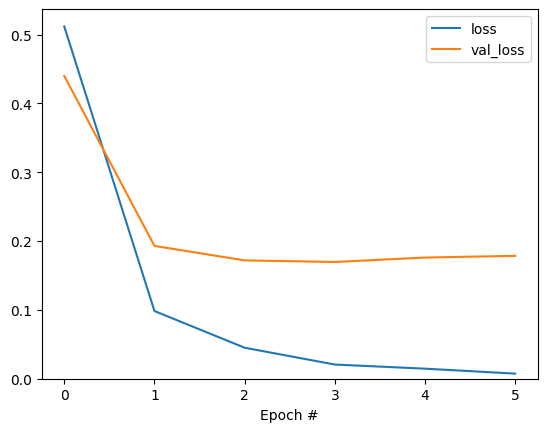

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.legend()
plt.show()

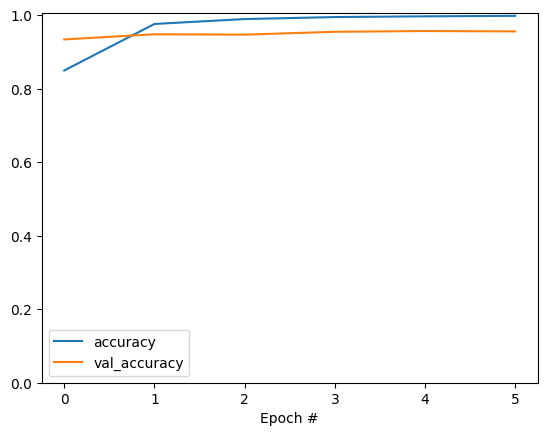

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.legend()
plt.show()

### Detector Class

In [ ]:
class LanguageDetector(tf.Module):
    def __init__(self, text_processor, model, Languages):
        self.model = model
        self.text_processor = text_processor
        self.Languages = Languages
    
    def __call__(self, sentence):
        sentence = self.text_processor(sentence)
        predicted_index = tf.argmax(self.model(tf.reshape(sentence, shape=(1, -1))), axis=1)
        predicted_language = tf.gather(self.Languages, predicted_index)
        predicted_language = predicted_language[()]
        return predicted_language

languageDetector = LanguageDetector(text_processor, model, Languages)

In [ ]:
sentence = "انا لا اشعر بالعطش"
language = languageDetector(sentence)
print("Detected Language is: ",language.numpy()[0].decode())

Detected Language is:  Arabic


In [ ]:
sentence = "This castle is amazing"
language = languageDetector(sentence)
print("Detected Language is: ",language.numpy()[0].decode())

Detected Language is:  English


### Saving the model

In [ ]:
class Export(tf.Module):
    def __init__(self, languageDetector):
        self.languageDetector = languageDetector

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        result = self.languageDetector(sentence)
        return result

In [ ]:
export = Export(languageDetector)
tf.saved_model.save(export, export_dir='languageDetector')

In [ ]:
reloaded = tf.saved_model.load('/content/languageDetector')

In [ ]:
%%time
print("Prediction is: ", reloaded(sentence).numpy()[0].decode())
print()

Prediction is:  English

CPU times: user 700 ms, sys: 10.6 ms, total: 711 ms
Wall time: 717 ms


In [ ]:
# downloading the model
import shutil
folder_path = '/content/languageDetector'

# Creating a zip file of the folder
shutil.make_archive('/content/languageDetector', 'zip', folder_path)

'/content/languageDetector.zip'